In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
!ls

/content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
current_regulator_rule.ipynb	     PlotRewardStructure.ipynb
DataAnalysis.ipynb		     surrogate_studies-newdata.ipynb
HEP-NoisyStackedLSTM-Model_v1.ipynb


In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

def load_data():
    df = pd.read_csv('../data/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')
    #/data/fermilab-accelerator-ai/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5.cvs')
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna(axis=0)
    #df=df.round(decimals=5)
    return df

df = load_data()
print(df.head())

                      time   B:ACMNPG  ...     I:MDAT40       I:MXIB
0  2020-03-10 05:00:00.048  10.000006  ...  6977.386446  6974.145508
1  2020-03-10 05:00:00.114  10.000006  ...  6261.596654  6250.284180
2  2020-03-10 05:00:00.180  10.000006  ...  5105.590799  5093.851074
3  2020-03-10 05:00:00.246  10.000006  ...  3989.562972  3978.289795
4  2020-03-10 05:00:00.312  10.000006  ...  2907.409656  2896.432617

[5 rows x 15 columns]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>


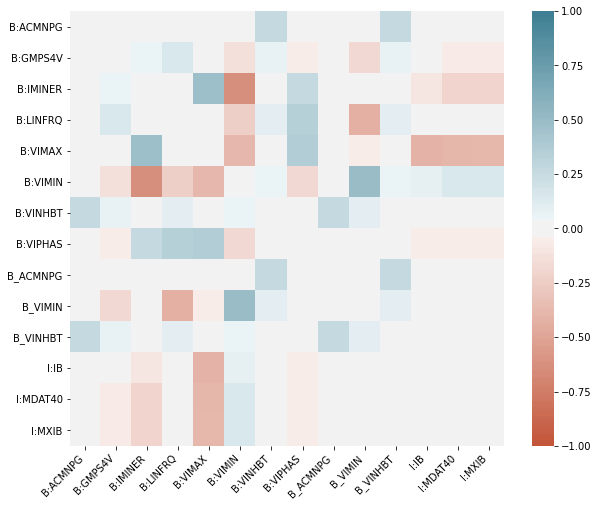

In [ ]:
#####################################
## PLOT BASIC CORRELATION FUNCTION ##
#####################################
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
corr[corr > 0.9] = 0
print(type(corr))
c = corr.abs()
s = c.unstack()
so = s.sort_values(ascending = False)
#print(so.columns)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
#####################################
## GET TOP 5 CORRELATED VARIABLES ##
#####################################
    
def top_5(variable_name, df):
    df = df.corr()
    df[df > 0.9] = 0
    df = df.unstack().sort_values(ascending = False).reset_index()
    df = df.rename(columns={"level_0": "Var1", "level_1": "Var2", 0 : "Corr"})
    df = df[~df["Var2"].str.endswith(str(df.Var1.tolist()[0][2:]))]
    df['Abs Value Corr'] = np.abs(df.Corr)
    df = df.sort_values(by = 'Abs Value Corr', ascending = False)
    
    print("Highest Correlations to {}: ".format(variable_name))
    print(df[['Var2', 'Corr']][df.Var1 == str(variable_name)].head().to_string(index = False))

    return(df[['Var2', 'Corr']][df.Var1 == str(variable_name)].head())

col_1 = top_5('B:VIMIN', df)
print()
col_2 = top_5('B:IMINER', df)

Highest Correlations to B:VIMIN: 
     Var2      Corr
 B:IMINER -0.630672
  B:VIMAX -0.374856
 B:LINFRQ -0.231286
 B:VIPHAS -0.186792
   I:MXIB  0.150411

Highest Correlations to B:IMINER: 
     Var2      Corr
  B:VIMAX  0.469405
 B:VIPHAS  0.259610
   I:MXIB -0.205465
 I:MDAT40 -0.204521
     I:IB -0.098573


In [ ]:
var1 = col_1.Var2.tolist()
var1.append('B:VIMIN')

var2 = col_2.Var2.tolist()
var2.append('B:IMINER')

Highest Correlations to 'B:VIMIN'.


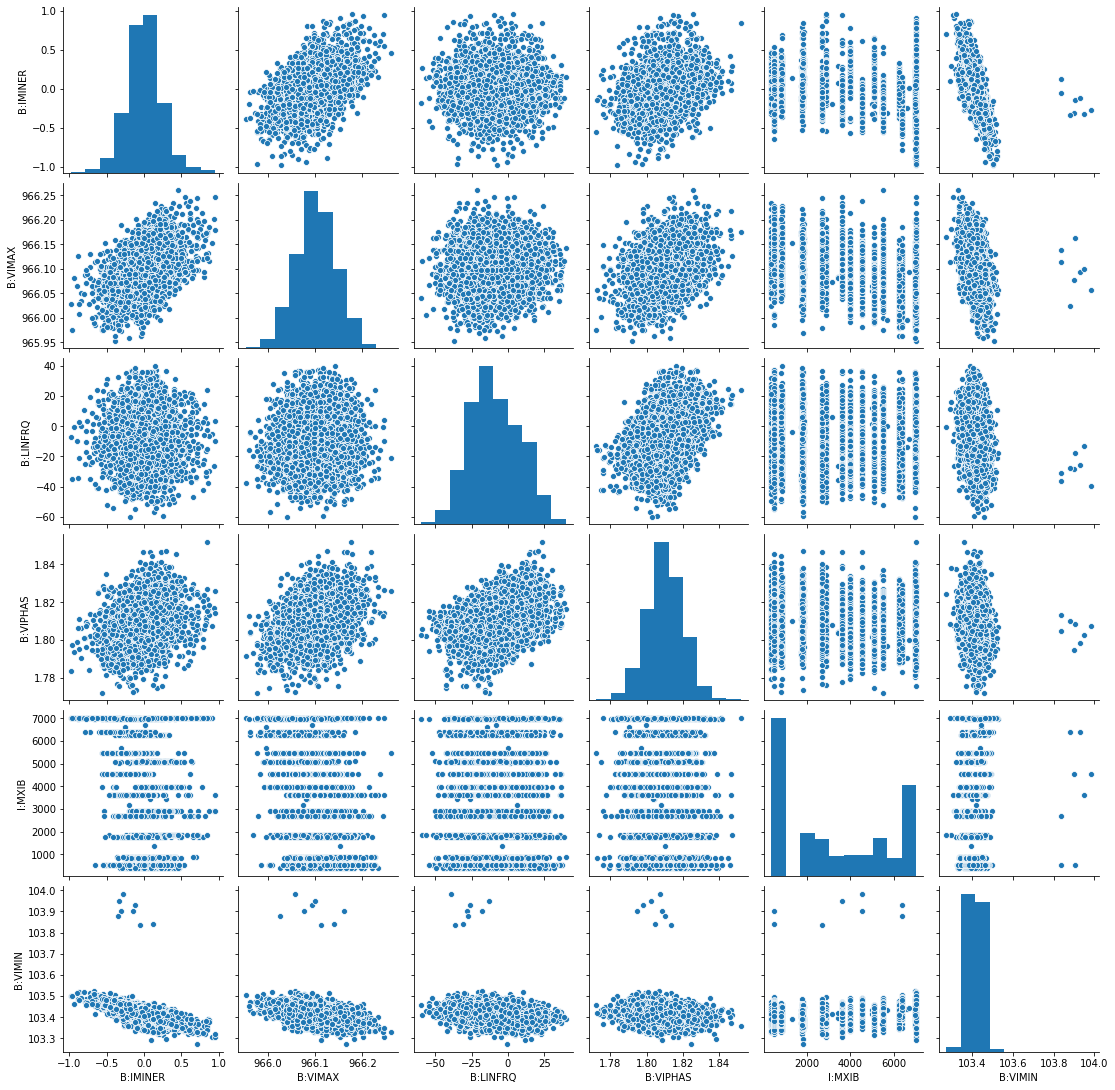

In [ ]:
print("Highest Correlations to 'B:VIMIN'.")
sns.pairplot(df[var1].sample(5000),dropna=True);

Highest Correlations to 'B:IMINER'.


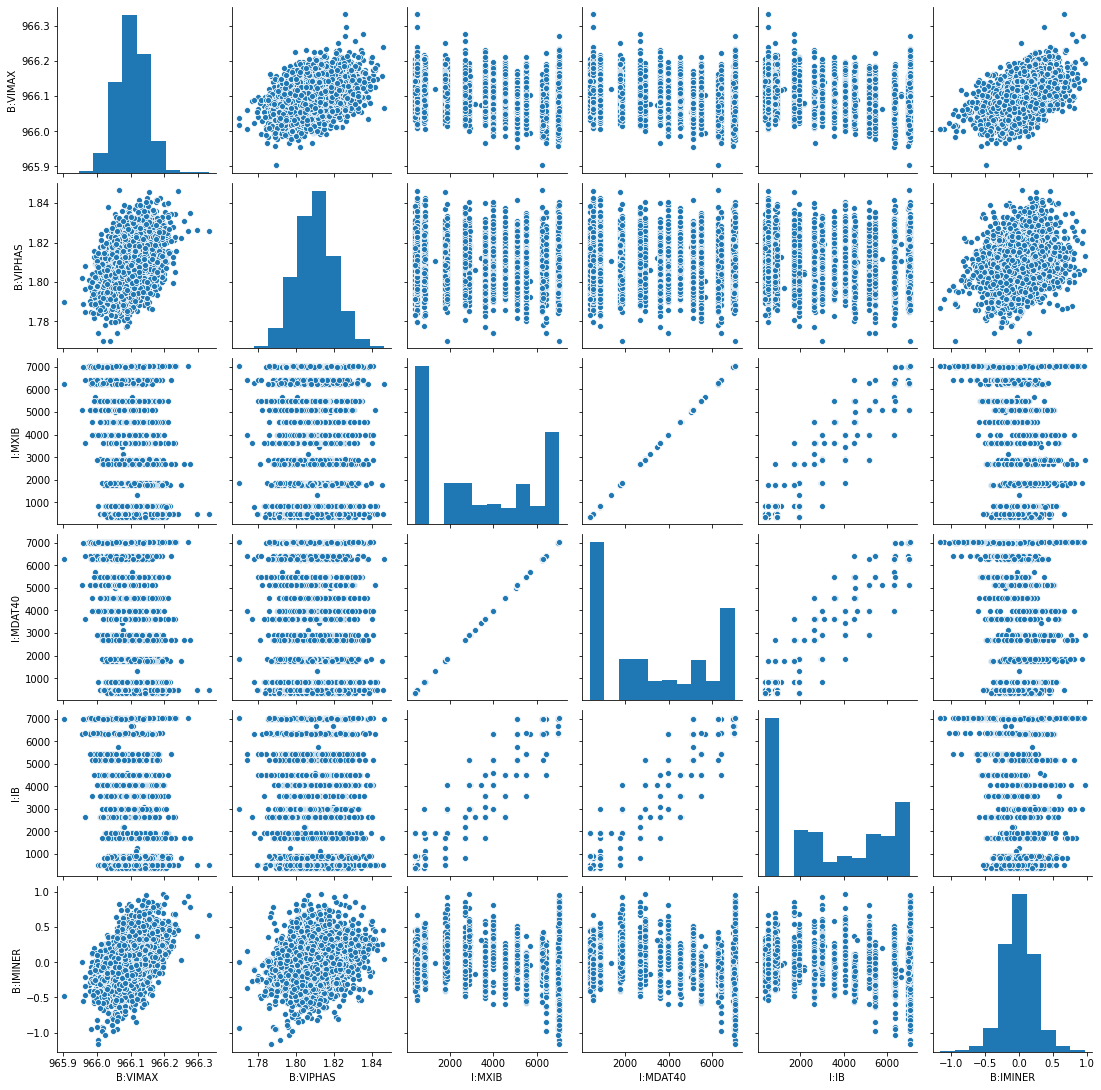

In [ ]:
print("Highest Correlations to 'B:IMINER'.")
sns.pairplot(df[var2].sample(5000),dropna=True);

In [ ]:
#frequency analysis

def frequency_analyzer(df,variable_list,num_signals,list_index):
    
    import scipy.fftpack as fft
    import matplotlib.pyplot as plt
    %matplotlib inline

    end = num_signals
    var = list_index
    var1 = variable_list

    x = np.arange(0,end,1)
    y = df[var1][var1[var]][:end]

    freq = fft.rfftfreq(x.size)
    yhat = fft.rfft(np.asarray(y))
    
    fig, axs = plt.subplots(4, 1, figsize=(15,10))
    axs[0].plot(x, y)
    axs[0].set_title(str(var1[var])+' Signal Trace')
    axs[0].set(xlabel = 'Time', ylabel= 'Amplitude')
    axs[1].plot(x, y.rolling(window=15).mean(), 'tab:purple')
    axs[1].set_title(str(var1[var])+' Rolling Average')
    axs[1].set(xlabel = 'Time', ylabel= 'Amplitude')
    axs[2].plot(x, y.rolling(window=15).std(), 'tab:green')
    axs[2].set_title(str(var1[var])+' Rolling Standard Deviation')
    axs[2].set(xlabel = 'Time', ylabel= 'Amplitude')
    axs[3].plot(freq, yhat, 'tab:orange')
    axs[3].set_title(str(var1[var])+' Frequency Decomposition')
    axs[3].set(xlabel = 'Frequency', ylabel = 'Magnitude')
    plt.tight_layout()

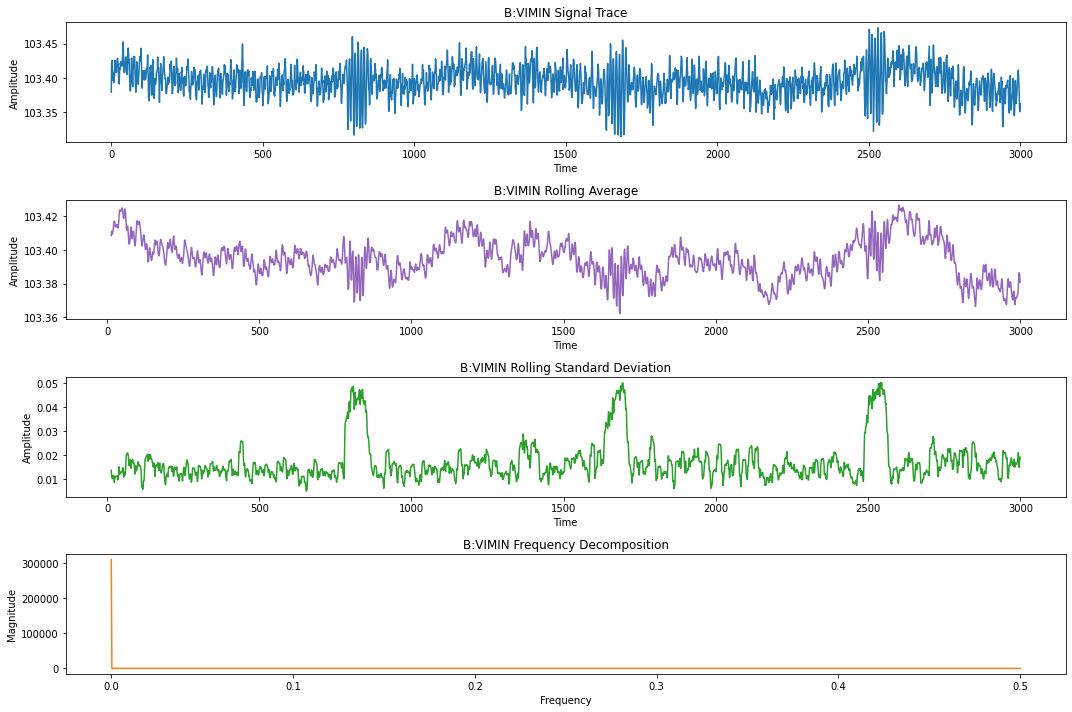

In [ ]:
#need to run for list_index:[0,7] for unique elements after combining both var1 and var2
combined_list = var1 + list(set(var2) - set(var1))

frequency_analyzer(df,combined_list,3000,list_index=5)

In [4]:
import scipy.fftpack as fft

variable_list = df.columns.tolist()
variable_list.remove('time')

new_df = df

for i in variable_list:
  #new_df['Avg '+str(i)] = df[str(i)].rolling(window=15).mean()
  new_df['Std '+str(i)] = df[str(i)].rolling(window=15).std()
  new_df['Freq '+str(i)] = pd.Series(fft.rfft(np.asarray(df[str(i)])))

In [6]:
#####################################
## GET TOP 5 CORRELATED VARIABLES (INCLUDING ROLLING MEAN AND STD) ##
#####################################


def top_5_rolling_values(variable_name, df):
    new_df = df.drop(columns = ['Std '+str(variable_name), 'Freq '+str(variable_name)])
    #new_df = df.drop(columns = ['Avg '+str(variable_name), 'Std '+str(variable_name), 'Freq '+str(variable_name)])
    new_df = new_df.corr()
    new_df[new_df > 0.9] = 0
    new_df = new_df.unstack().sort_values(ascending = False).reset_index()

    new_df = new_df.rename(columns={"level_0": "Var1", "level_1": "Var2", 0 : "Corr"})
    new_df = new_df[~new_df["Var2"].str.endswith(str(variable_name)[2:])]
    new_df['Abs Value Corr'] = np.abs(new_df.Corr)
    new_df = new_df.sort_values(by = 'Abs Value Corr', ascending = False)
    
    print("Highest Correlations to {}: ".format(variable_name))
    print(new_df[['Var2', 'Corr']][new_df.Var1 == str(variable_name)].head().to_string(index = False))

    return(new_df[['Var2', 'Corr']][new_df.Var1 == str(variable_name)].head())

col_1 = top_5_rolling_values('B:VIMIN', df)
print()
col_2 = top_5_rolling_values('B:IMINER', df)

Highest Correlations to B:VIMIN: 
         Var2      Corr
     B:IMINER -0.630672
      B:VIMAX -0.374856
 Std B:GMPS4V -0.309329
     B:LINFRQ -0.231286
     B:VIPHAS -0.186792

Highest Correlations to B:IMINER: 
     Var2      Corr
  B:VIMIN -0.630672
  B:VIMAX  0.469405
 B:VIPHAS  0.259610
 Std I:IB  0.207653
   I:MXIB -0.205465
